# Определение возраста покупателей

## Импорт библиотек

#### Для анализа и подготовки данных

In [ ]:
## Для работы с данными:
# Импортируем pandas как pd:
import pandas as pd
# Импортируем numpy как np:
import numpy as np
# Импортируем ImageNet для загрузки фотографий:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Для работы с фотографиями:
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image

## Импорт библиотек для граффиков:
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly
import plotly.graph_objects as go
import seaborn as sns


#### Для работы с моделью

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras

## Исследовательский анализ данных

### Загрузка данных

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
df = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


У нас есть 7591 фотография с возрастом человека изображённого на нём.

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


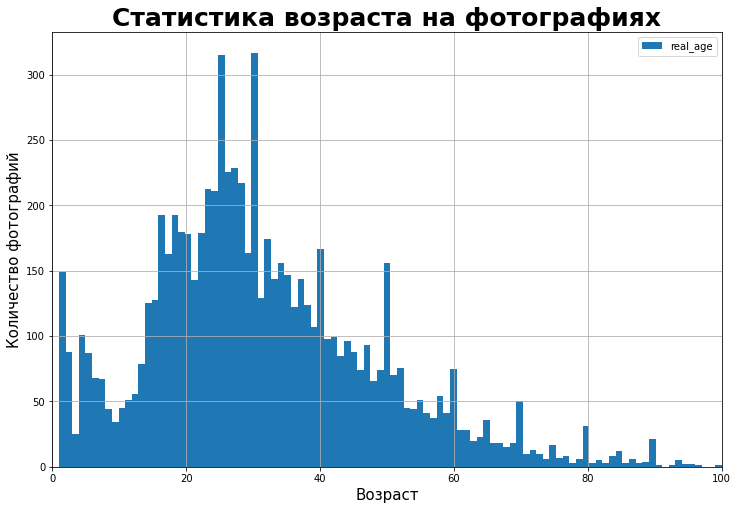

In [ ]:
labels.plot(kind='hist', bins=100, figsize=(12,8), grid=True, xlim=(0,100))
plt.xlabel("Возраст", fontsize=15)
plt.ylabel("Количество фотографий", fontsize=15)
plt.title(label='Статистика возраста на фотографиях', loc='center', fontsize=25, fontweight='bold')
labels.describe().T

Количество изображений и меток совпадает.

На граффике есть пик в возрасте 24-30 лет, в остальном данные распределенны нормально.

На отметке 30, а также последующих лет кратным 10 есть небольшие скачки, думаю это связанно с округлением возраста, если точный был неизвестен.

Выгрузим 15 случайных картинок и добавим к ним значение целевого признака(возраст)

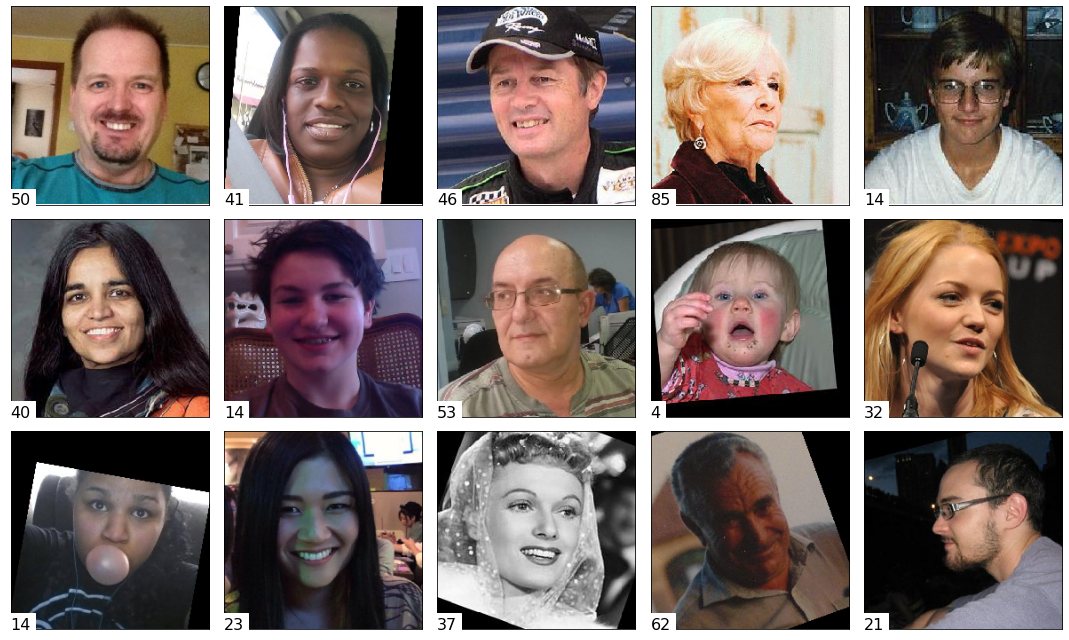

In [ ]:
x, y = next(df)
fig = plt.figure(figsize=(15,9))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(x[i])
    plt.text(0, 0, y[i], fontsize = 16, transform=ax.transAxes,
             color='black', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Как мы видим фотографии – квадратные. В центре фотографии изображенны люди до груди, в основном повёрнуты лицом к камере.

Посмотрим разрешение изображений

In [ ]:
img_path = '/datasets/faces/final_files/'
img_sizes = labels.copy().set_index('file_name')
for file_name in tqdm(labels.file_name):
    img = Image.open(img_path+file_name)
    img_sizes.loc[file_name, ['h','w']] = img.size

img_sizes.sample(10)

  0%|          | 0/7591 [00:00<?, ?it/s]

,real_age,h,w
file_name,,,
006120.jpg,45,178.0,178.0
006650.jpg,30,119.0,120.0
001218.jpg,30,202.0,201.0
001913.jpg,24,689.0,689.0
005108.jpg,32,434.0,434.0
007386.jpg,50,111.0,111.0
005167.jpg,38,239.0,239.0
003586.jpg,70,379.0,379.0
005397.jpg,19,131.0,131.0


Изображения имеют разное разрешение, но это не проблема, так как метод-итератор класса **ImageDataGenerator** приведёт их к одинаковому разрешению. Мы будем использовать размер (224, 224), который задан по умолчанию для модели ResNet50.

Отобразим какое количество изображений имеют неправильное соотношение сторон

In [ ]:
# Выгрузим количество фотографий неквадратной формы:
img_sizes['is_square'] = (img_sizes.h - img_sizes.w) <= 1
(~img_sizes.is_square).sum()

117

Выведем 15 случайных изображений с неправильным соотношением сторон

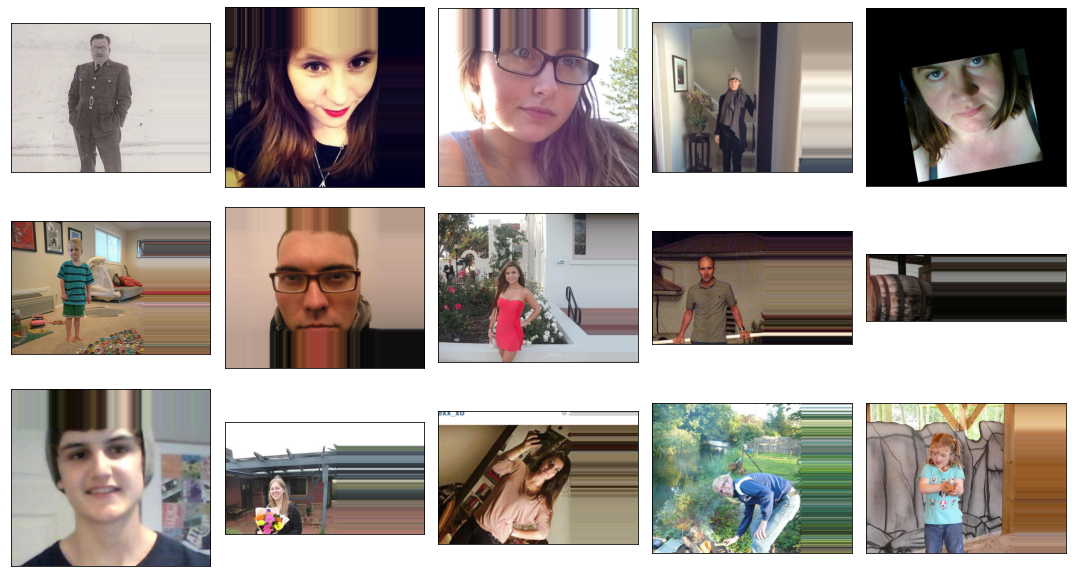

In [ ]:
fig = plt.figure(figsize=(15,9))
i = 0
for file_name in img_sizes[~img_sizes.is_square].sample(15).index:
    i += 1
    fig.add_subplot(3, 5, i)
    plt.imshow(Image.open(img_path+file_name))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Как мы можем наблюдать, данные фотографии имеют прямоугольную форму. Метод-итератор класса ImageDataGenerator приведёт их к квадратным, но тем самым исказив.
Кроме этого на большинстве из них есть артифакты, а также есть фотографии, где изображены люди в полный рост или людей вовсе нет. Предпологаю, что связанно это с проблемами в детекции изображений.
Все эти проблемы приведут к ухудшению обучения модели.

### Вывод:

У нас есть 7591 фотографии с изображением людей на них. Этого достаточно, чтобы решить нашу задачу и модель до требуемой точности. Фотографии преимущественно квадратной формы, люди изображенны в основном центре, цветовая гамма отличается на фотографиях: от ч/б и близких тоннов, до отлично различимых цветов. Фотографии могут быть отдаленны и повёрнуты в сравнении с исходником, это сделанно для лучшего анализа изображений модель.

Также есть изображения с 'ошибками' в количестве 117: Артефакты, люди в полный рост, присутсвие других людей в кадре, либо их полное отсутвие – всё это ухудшит обучение и итоговую точность модели.

Проанализировав целевой признак(возраст) наших данных можно отметить:

Минимальный возраст – 1 год, максимальный – 100 лет. Оснавная часть фотографий сконцентрированна в промежутке 17-40 лет. Главный пик: 24-30 лет. После 40 лет можно заметить пик каждый юбилейный год 50, 60 и т.д. лет. Предпологаюсвязанно, что это связанно с не очень качественной разметки части данных

## Обучение модели

```python
# Импорт библиотек:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd

# Загрузка данных для обучения:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )

# Загрузка данных для теста:
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )

# Создание моделей
def create_model(input_shape):
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape,
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Обучение модели
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-10-13 11:08:33.474260: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-13 11:08:33.865500: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 150s - loss: 766.5831 - mean_absolute_error: 22.9842 - val_loss: 1165.6652 - val_mean_absolute_error: 29.5538
Epoch 2/20
178/178 - 94s - loss: 211.6966 - mean_absolute_error: 11.1100 - val_loss: 1125.8928 - val_mean_absolute_error: 28.8701
Epoch 3/20
178/178 - 104s - loss: 118.8797 - mean_absolute_error: 8.1456 - val_loss: 1092.4709 - val_mean_absolute_error: 28.4195
Epoch 4/20
178/178 - 103s - loss: 89.9705 - mean_absolute_error: 7.1117 - val_loss: 212.7565 - val_mean_absolute_error: 10.6911
Epoch 5/20
178/178 - 106s - loss: 76.3028 - mean_absolute_error: 6.6449 - val_loss: 94.9175 - val_mean_absolute_error: 7.3362
Epoch 6/20
178/178 - 101s - loss: 65.5609 - mean_absolute_error: 6.1992 - val_loss: 86.1559 - val_mean_absolute_error: 6.7975
Epoch 7/20
178/178 - 93s - loss: 58.2803 - mean_absolute_error: 5.8626 - val_loss: 85.4103 - val_mean_absolute_error: 6.7611
Epoch 8/20
178/178 - 94s - loss: 53.4996 - mean_absolute_error: 5.5638 - val_loss: 80.2196 - val_mean_absolute_error: 6.5906
Epoch 9/20
178/178 - 93s - loss: 49.7491 - mean_absolute_error: 5.4521 - val_loss: 85.1975 - val_mean_absolute_error: 6.8023
Epoch 10/20
178/178 - 93s - loss: 45.7610 - mean_absolute_error: 5.2207 - val_loss: 83.2770 - val_mean_absolute_error: 6.6543
Epoch 11/20
178/178 - 99s - loss: 41.0145 - mean_absolute_error: 4.9631 - val_loss: 81.9958 - val_mean_absolute_error: 6.5948
Epoch 12/20
178/178 - 104s - loss: 38.7219 - mean_absolute_error: 4.8245 - val_loss: 82.1405 - val_mean_absolute_error: 6.6122
Epoch 13/20
178/178 - 95s - loss: 36.3535 - mean_absolute_error: 4.6916 - val_loss: 89.5586 - val_mean_absolute_error: 7.1026
Epoch 14/20
178/178 - 99s - loss: 34.3617 - mean_absolute_error: 4.5573 - val_loss: 83.6556 - val_mean_absolute_error: 6.6481
Epoch 15/20
178/178 - 106s - loss: 32.9680 - mean_absolute_error: 4.4701 - val_loss: 81.2748 - val_mean_absolute_error: 6.5620
Epoch 16/20
178/178 - 103s - loss: 30.8789 - mean_absolute_error: 4.3326 - val_loss: 80.3622 - val_mean_absolute_error: 6.4985
Epoch 17/20
178/178 - 104s - loss: 29.7580 - mean_absolute_error: 4.2625 - val_loss: 78.0283 - val_mean_absolute_error: 6.5174
Epoch 18/20
178/178 - 107s - loss: 29.1327 - mean_absolute_error: 4.2183 - val_loss: 79.4525 - val_mean_absolute_error: 6.4706
Epoch 19/20
178/178 - 105s - loss: 27.8916 - mean_absolute_error: 4.1095 - val_loss: 82.1901 - val_mean_absolute_error: 6.6307
Epoch 20/20
178/178 - 106s - loss: 26.1423 - mean_absolute_error: 3.9528 - val_loss: 90.0930 - val_mean_absolute_error: 6.9188
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
```

## Анализ обученной модели

Мы использовали модель ResNet с архитектурой backbone + голова, с предобученными весами. В качестве оптимизатора использовался Adam и learning_rate равный 0.00001

Модель достигла метрики MAE = 6.9 за 20 эпох

В среднем модель ошибается примерно на 6.5-7 лет при предсказании возраста на тестовой выборке и на 4 на тренировочной. Модель переобучилась.

Можно улучшить качество предсказаний модели, если:

-Обучать модель на большем количестве циклов обучения

-Избавиться от ошибок в детекции лиц в изображениях датасета.

Требуемое значение метрики MAE < 8 получено